## 首次运行

当前文件运行路径是“/mmsegmentation/demo/”

运行前需在/mmsegmentation下创建checkpoints文件夹用于存放预训练模型

ade数据集需要放置在和mmsegmentation同一层目录下

### 下载模型（仅需下载一次）

#### pspnet_r50-d8_512x512_80k_ade20k

In [ ]:
!wget https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x512_80k_ade20k/pspnet_r50-d8_512x512_80k_ade20k_20200615_014128-15a8b914.pth -P ../checkpoints

#### deeplabv3plus_r50-d8_512x512_80k_ade20k

In [ ]:
!wget https://download.openmmlab.com/mmsegmentation/v0.5/deeplabv3plus/deeplabv3plus_r50-d8_512x512_80k_ade20k/deeplabv3plus_r50-d8_512x512_80k_ade20k_20200614_185028-bf1400d8.pth -P ../checkpoints

#### fcn_r50-d8_512x512_80k_ade20k

In [ ]:
!wget https://download.openmmlab.com/mmsegmentation/v0.5/fcn/fcn_r50-d8_512x512_80k_ade20k/fcn_r50-d8_512x512_80k_ade20k_20200614_144016-f8ac5082.pth -P ../checkpoints 

### 安装mmcv和mmseg （本地运行仅需运行一次）

In [ ]:
!pip3 install openmim
!mim install mmcv-full
!pip install mmsegmentation

## 日常运行开始点

### 调整当前运行路径

In [34]:
# 根据自己的路径修改
%cd /home/kyletian/SSY340-DeepLearning/Project/mmsegmentation/demo

/home/kyletian/SSY340-DeepLearning/Project/mmsegmentation/demo


### 运行必备库

In [35]:
import cv2 as cv
import matplotlib.pyplot as plt
from torchvision.transforms import Compose
import torchvision.transforms as transforms
from dataset_tools import ADE20KDataset
from tools import inference_img
import numpy as np
from PIL import Image

from torch import nn
import torch.nn.functional as F
import torch
from mmseg.core.evaluation import metrics
from tools import majorVote
import matplotlib.pyplot as plt
from collections import Counter

import pickle

### 配置config以及预训练模型

In [36]:
from mmseg.apis import init_segmentor, inference_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

pspnet_config_file = '../configs/pspnet/pspnet_r50-d8_512x512_80k_ade20k.py'
pspnet_checkpoint_file = '../checkpoints/pspnet_r50-d8_512x512_80k_ade20k_20200615_014128-15a8b914.pth'

deeplabv3plus_config_file = '../configs/deeplabv3plus/deeplabv3plus_r50-d8_512x512_80k_ade20k.py'
deeplabv3plus_checkpoint_file = '../checkpoints/deeplabv3plus_r50-d8_512x512_80k_ade20k_20200614_185028-bf1400d8.pth'

fcn_config_file = '../configs/fcn/fcn_r50-d8_512x512_80k_ade20k.py'
fcn_checkpoint_file = '../checkpoints/fcn_r50-d8_512x512_80k_ade20k_20200614_144016-f8ac5082.pth'

# build the model from a config file and a checkpoint file
# model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

pspnet_model = init_segmentor(pspnet_config_file, pspnet_checkpoint_file, device='cuda:0')

deeplabv3plus_model = init_segmentor(deeplabv3plus_config_file, deeplabv3plus_checkpoint_file, device='cuda:0')

fcn_model = init_segmentor(fcn_config_file, fcn_checkpoint_file, device='cuda:0')

/home/kyletian/SSY340-DeepLearning/Project/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: ../checkpoints/pspnet_r50-d8_512x512_80k_ade20k_20200615_014128-15a8b914.pth
load checkpoint from local path: ../checkpoints/deeplabv3plus_r50-d8_512x512_80k_ade20k_20200614_185028-bf1400d8.pth
load checkpoint from local path: ../checkpoints/fcn_r50-d8_512x512_80k_ade20k_20200614_144016-f8ac5082.pth


### 加载数据集

In [37]:
train_path = '../../ADEChallengeData2016/images/training/'
train_label_path = '../../ADEChallengeData2016/annotations/training/'
val_path = '../../ADEChallengeData2016/images/validation/'
val_label_path = '../../ADEChallengeData2016/annotations/validation/'

transform = Compose([transforms.ToTensor()])
ADE20KDataset = ADE20KDataset(train_path, train_label_path, transform)


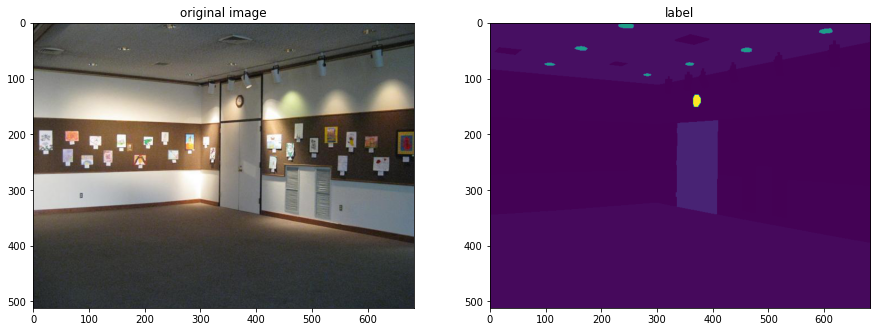

In [38]:
# 读取图片
idx = 2

img = ADE20KDataset.get_img_as_PIL(idx)
label = ADE20KDataset.get_label_as_PIL(idx)

plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('original image')

plt.subplot(1, 2, 2)
plt.imshow(label)
plt.title('label')

plt.show()

### 定义推理接口 inference_img(my_model, img_path) 返回logits

In [ ]:
img_path = str(ADE20KDataset.get_img_path(idx))

deeplabv3p_logits_res = inference_img(deeplabv3plus_model, img_path)[0]
pspnet_logits_res = inference_img(pspnet_model, img_path)[0]
fcn_logits_res = inference_img(fcn_model, img_path)[0]

In [ ]:
deeplabv3p_logits_res.shape

### 调用mmsegementation的推理接口，返回正常mask

In [ ]:
pspnet_result = inference_segmentor(pspnet_model, img_path)
fcn_result = inference_segmentor(fcn_model, img_path)
deeplabv3p_result = inference_segmentor(deeplabv3plus_model, img_path)
# show_result_pyplot(pspnet_model, img_path, result, get_palette('ade20k'))

pspnet_result = np.array(pspnet_result[0], dtype = np.uint8)
fcn_result = np.array(fcn_result[0], dtype = np.uint8)
deeplabv3p_result = np.array(deeplabv3p_result[0], dtype = np.uint8)

pspnet_result += 1
fcn_result += 1
deeplabv3p_result += 1

In [ ]:

pspnet_seg = Image.fromarray(pspnet_result)
fcn_seg = Image.fromarray(fcn_result)
deeplabv3p_seg = Image.fromarray(deeplabv3p_result)

plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.imshow(label)
plt.title('label')

plt.subplot(2, 2, 2)
plt.imshow(pspnet_seg)
plt.title('pspnet_seg')

plt.subplot(2, 2, 3)
plt.imshow(fcn_seg)
plt.title('fcn_seg')

plt.subplot(2, 2, 4)
plt.imshow(deeplabv3p_seg)
plt.title('deeplabv3p_seg')

plt.show()

### Major Vote

In [ ]:
from tools import majorVote
fuse_res = majorVote(pspnet_result, fcn_result, deeplabv3p_result).astype(np.uint8)
fuse_seg = Image.fromarray(fuse_res)

plt.figure(figsize=(15,10))

plt.subplot(2, 3, 1)
plt.imshow(fuse_seg)
plt.title('Major vote')

plt.subplot(2, 3, 2)
plt.imshow(pspnet_seg)
plt.title('pspnet_seg')

plt.subplot(2, 3, 3)
plt.imshow(fcn_seg)
plt.title('fcn_seg')

plt.subplot(2, 3, 4)
plt.imshow(deeplabv3p_seg)
plt.title('deeplabv3p_seg')

plt.subplot(2, 3, 5)
plt.imshow(label)
plt.title('label')

plt.show()

### Mean IoU使用

In [ ]:
from mmseg.core.evaluation import metrics

vote_IoU_result = metrics.mean_iou([label], [fuse_res], 150, 0)
fcn_IoU_result = metrics.mean_iou([label], [fcn_result], 150, 0)
deeplabv3p_IoU_result = metrics.mean_iou([label], [deeplabv3p_result], 150, 0)
pspnet_IoU_result = metrics.mean_iou([label], [pspnet_result], 150, 0)

In [ ]:
print("Vote mIoU: " + str(np.nanmean(vote_IoU_result['IoU'])))
print("FCN mIoU: " + str(np.nanmean(fcn_IoU_result['IoU'])))
print("Deeplabv3plus mIoU: " + str(np.nanmean(deeplabv3p_IoU_result['IoU'])))
print("PSPnet mIoU: " + str(np.nanmean(pspnet_IoU_result['IoU'])))

### TODO：


*   三个模型的集成模型



#### 对于训练集的每一张图片，求四个模型的IoU，并且最后得出一张直方图，看每一张图片里哪种方法的 IoU 最好

In [ ]:
inference_num = 10 # 推理数量
img_path = [ADE20KDataset.get_img_path(i) for i in range(inference_num)]
img_name = [ADE20KDataset.get_img_name(i) for i in range(inference_num)]
pspnet_result = inference_segmentor(pspnet_model, img_path)

In [43]:
BestMethods_4each = np.array([],dtype=np.uint8)

nTrainImgs = len(ADE20KDataset)
# nTrainImgs = 100
for idx in range(nTrainImgs):
    img_path = str(ADE20KDataset.get_img_path(idx))
    label_path = str(ADE20KDataset.get_label_path(idx))
    img = ADE20KDataset.get_img_as_ndarray(idx)
    label = ADE20KDataset.get_label_as_ndarray(idx)

    pspnet_result = inference_segmentor(pspnet_model, img_path)
    fcn_result = inference_segmentor(fcn_model, img_path)
    deeplabv3p_result = inference_segmentor(deeplabv3plus_model, img_path)
    pspnet_result = np.array(pspnet_result[0], dtype = np.uint8) + 1
    fcn_result = np.array(fcn_result[0], dtype = np.uint8) + 1
    deeplabv3p_result = np.array(deeplabv3p_result[0], dtype = np.uint8) + 1
    # pspnet_result += 1
    # fcn_result += 1
    # deeplabv3p_result += 1
    fuse_res = majorVote(pspnet_result, fcn_result, deeplabv3p_result).astype(np.uint8)

    vote_IoU_result = metrics.mean_iou([label], [fuse_res], 150, 0)
    fcn_IoU_result = metrics.mean_iou([label], [fcn_result], 150, 0)
    deeplabv3p_IoU_result = metrics.mean_iou([label], [deeplabv3p_result], 150, 0)
    pspnet_IoU_result = metrics.mean_iou([label], [pspnet_result], 150, 0)

    IoU_results = np.array([np.nanmean(vote_IoU_result['IoU']), 
                    np.nanmean(fcn_IoU_result['IoU']), 
                    np.nanmean(deeplabv3p_IoU_result['IoU']), 
                    np.nanmean(pspnet_IoU_result['IoU'])])
    BestMethods_4each = np.append(BestMethods_4each, np.argmax(IoU_results))




RuntimeError: CUDA out of memory. Tried to allocate 1.32 GiB (GPU 0; 3.95 GiB total capacity; 1.86 GiB already allocated; 336.69 MiB free; 2.65 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [46]:
file = open('BestMethod_Statistics.txt', 'wb')
pickle.dump(BestMethods_4each, file)
file.close()

In [47]:
file = open('BestMethod_Statistics.txt', 'rb')
a = pickle.load(file)
file.close()
print(a)

[3 3 2 2 0 0 0 3 3 0 2 0 2 0 0 2 2 2 2 2 2 1 1 0 2 0 0 2 2 0 0 0 0 3 1 3 0
 2 0 0 0 2 2 2 2 0 0 2 2 0 0 3 0 0 3 0 2 2 2 2 2 1 2 2 0 2 1 0 2 0 3 2 0 3
 3 3 3 2 0 2 1 0 2 3 2 3 1 2 3 0 2 0 0 0 1 2 3 2 0 2 3 3 0 0 0 3 2 0 0 2 0
 0 2 2 3 0 2 1 2 2 2 1 3 2 2 0 0 0 1 2 3 0 0 0 0 2 0 0 1 0 2 2 0 0 0 2 3 0
 0 1 0 2 2 0 0 3 0 0 2 1 0 2 1 2 3 2 0 0 1 3 1 2 2 2 0 2 2 3 2 0 0 0 3 2 2
 0 2 3 0 0 0 2 1 3 1 3 3 0 0 0 0 1 0 1 3 2 3 3 2 2 0 0 3 0 3 0 3 1 1 0 0 2
 1 3 0 2 1 3 0 1 0 0 2 3 3 3 1 0 3 3 0 0 0 0 0 3 0 3 2 3 3 2 1 3 2 0 0 3 0
 3 0 3 0 1 2 0 2 0 1 2 3 2 3 1 0 2 0 3 1 2 0 3 0 2 0 0 0 3 0 1 0 0 3 3 3 2
 0 3 2 1 2]


(301,)
Counter({0: 115, 2: 89, 3: 63, 1: 34})


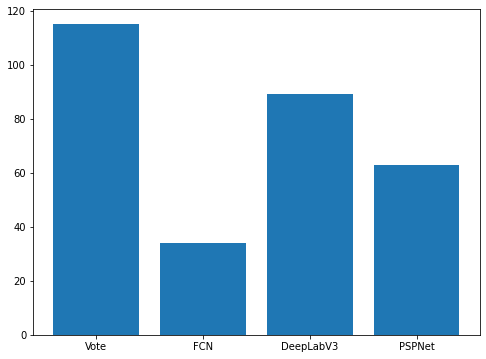

In [48]:
'''
0. Vote 方法
1. FCN 方法
2. DeepLabV3 方法
3. PSPNet 方法
'''
print(BestMethods_4each.shape)
statistic = Counter(BestMethods_4each)
print(statistic)
BestMethods = []
for i in range(4):
    BestMethods.append(statistic[i])

labels = ['Vote', 'FCN', 'DeepLabV3', 'PSPNet']
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(6)
plt.bar(range(4), BestMethods, tick_label=labels)
plt.savefig("Performance", transparent=False)



### 定义Pytorch模型

In [ ]:

class FusionModel(nn.Module):
    '''
    输入: 三个模型的分割结果
    输出: 融合后的分割结果
    说明:
        每一个分割结果对应一个长度为150的向量, 每个向量的第i个元素表示第i类的权重
        三个分割结果的权重向量相加, 然后softmax, 得到最终的分割结果
    '''
    def __init__(self, class_num, device):
        super().__init__()
        # class_num: 150
        self.vec_1 = torch.from_numpy(np.random.rand(class_num)).reshape(class_num, 1, 1).to(device)
        self.vec_2 = torch.from_numpy(np.random.rand(class_num)).reshape(class_num, 1, 1).to(device)
        self.vec_3 = torch.from_numpy(np.random.rand(class_num)).reshape(class_num, 1, 1).to(device)
        
        self.Softmax = nn.Softmax()
        
    def forward(self, input_seg1, input_seg2, input_seg3):
        # input_seg size: (150, H, W)
        res_1 = input_seg1 * self.vec_1
        res_2 = input_seg2 * self.vec_2
        res_3 = input_seg3 * self.vec_3
        res = res_1 + res_2 + res_3
        # TODO: Softmax dim BUG HERE
        # res = self.Softmax(res, dim=0) 
        return res.argmax(0)


In [ ]:
device = "cpu"

model = FusionModel(150,device)
model.to(device)
'''
Size: (150, H, W)
Name:
    deeplabv3p_logits_res
    pspnet_logits_res
    fcn_logits_res
'''
deeplabv3p_logits_res = deeplabv3p_logits_res.to(device)
pspnet_logits_res = pspnet_logits_res.to(device)
fcn_logits_res = fcn_logits_res.to(device)
res = model.forward(deeplabv3p_logits_res, pspnet_logits_res, fcn_logits_res)

In [ ]:
res.argmax(0)

In [ ]:
ADE20KDataset.get_img_name(0)